
# BURST SEGMENTATION, UMAP & FEATURE HISTOGRAMS

This part of the code performs the following:
 1. Load electrophysiology recordings (.ABF files)
 2. Detect spikes and bursts in voltage traces
 3. Segment traces into bursts and non-bursts
 4. Classify burst waveform types (Parabolic, Square, Other)
 5. Extract detailed waveform features (170 per segment)
 6. Apply dimensionality reduction (UMAP)
 7. Visualize results using static and interactive plots
 8. Generate histograms for each feature type across bursts



- **1. IMPORT REQUIRED LIBRARIES**

 Here we import libraries for file handling, numerical computation, statistics,
 signal processing, feature scaling, dimensionality reduction, and plotting.

In [25]:
import os                          # File handling (listing files, constructing paths)
import pyabf                       # Read ABF electrophysiology files (Axon Binary Format)
import numpy as np                 # Numeric computations, array operations
import pandas as pd                # DataFrame for storing features
from scipy.stats import skew, kurtosis   # Compute asymmetry and peakedness of waveforms
from scipy.signal import find_peaks      # Detect spikes (local maxima) in voltage traces
from sklearn.preprocessing import StandardScaler   # Standardize features before UMAP
import umap                        # Dimensionality reduction (high-dimensional → 2D)
import matplotlib.pyplot as plt    # Static plotting
import seaborn as sns              # Advanced plotting (histograms, scatterplots)
import plotly.express as px        # Interactive plots
import plotly.io as pio
import math                        # Additional math functions

# Set Plotly renderer to open interactive plots in browser
pio.renderers.default = "browser"



- **2. PARAMETERS FOR ANALYSIS**

Define analysis parameters:
 - Thresholds for spike and burst detection
 - Sampling frequency and interval
 - Criteria for bursts
 These parameters control which voltage events are considered spikes/bursts.

In [26]:
folder_path = "bursting"   # Folder containing ABF recordings
threshold = -35            # Voltage threshold (mV) for spike detection
burst_threshold = 0.3      # Max interval (s) between spikes for a burst
fs = 10000                 # Sampling frequency (Hz)
dt = 1 / fs                # Sampling interval (s)

# Burst detection criteria
min_spikes_in_burst = 4    # Minimum spikes in a burst
max_isi = 0.3              # Maximum inter-spike interval (unused)
min_spike_rate = 5         # Optional filter (unused)
all_segment_metrics = []   # List to store features for all segments


- **3. LOAD ABF FILES AND ITERATE SWEEPS**

Read ABF files and loop through each sweep (epoch) to extract voltage traces.

Each sweep will later be analyzed for spikes, bursts, and features.

In [27]:
# List all ABF files in folder
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)   # Load ABF file

    # Loop through sweeps
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)        # Load a specific sweep
        time = abf.sweepX          # Time array (seconds)
        voltage = abf.sweepY       # Voltage array (mV)


        # 4. SPIKE DETECTION
        # Detect voltage peaks above threshold (spikes)
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs   # Convert indices to time (seconds)

     
        # 5. BURST DETECTION
        # Group spikes into bursts based on inter-spike intervals (ISI)
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)   # Time differences between consecutive spikes
            current_burst = [spike_times[0]]  # Start first burst
            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    current_burst.append(spike_times[i])  # Spike belongs to current burst
                else:
                    # End current burst if it meets minimum spike count
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]  # Start a new burst
            # Add the last burst if valid
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

   
        # 6. SEGMENT BURSTS AND NON-BURSTS
        # Define segments as bursts or non-bursts for feature extraction
        segments = [(start, end, "Burst") for start, end in bursts]

        # Identify non-burst intervals
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))  # Before first burst
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i + 1][0], "Non-burst"))  # Between bursts
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))  # After last burst
        else:
            segments.append((time[0], time[-1], "Non-burst"))  # Entire sweep non-burst

  
        # 7. CLASSIFY BURST WAVEFORM TYPES
        # Categorize bursts as "Square Wave", "Parabolic", or "Other"
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Compute baseline around burst (before and after)
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i - 1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments) - 1:
                    next_start = segments[i + 1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])

                inter_mean = np.nanmean([prev_mean, next_mean])  # Baseline voltage
                burst_min = np.min(seg_voltage)  # Minimum voltage of burst

                # Simple heuristic for burst type
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"
            burst_types.append(burst_type)


        # 8. FEATURE EXTRACTION
        # Extract 170 features per segment (10 fragments × 17 features)
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            # Count spikes within the segment
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)

            fragment_stats = []
            if len(seg_voltage) > 0:
                n = len(seg_voltage)
                fragment_len = max(1, n // 10)
                for i in range(10):
                    start_idx = i * fragment_len
                    end_idx = (i + 1) * fragment_len if i < 9 else n
                    frag = seg_voltage[start_idx:end_idx]

                    # Compute 17 features per fragment
                    if len(frag) == 0:
                        frag_stats = [np.nan] * 17
                    else:
                        deriv_frag = np.diff(frag) / dt if len(frag) > 1 else np.array([0.0])
                        frag_stats = [
                            np.mean(frag), np.std(frag), np.min(frag), np.max(frag),
                            skew(frag) if len(frag) > 2 else 0.0,
                            kurtosis(frag) if len(frag) > 3 else 0.0,
                            np.trapz(frag, dx=dt),                     # Area under curve
                            np.mean(deriv_frag), np.std(deriv_frag),
                            np.min(deriv_frag), np.max(deriv_frag),
                            skew(deriv_frag) if len(deriv_frag) > 2 else 0.0,
                            kurtosis(deriv_frag) if len(deriv_frag) > 3 else 0.0,
                            np.percentile(frag, 25),
                            np.percentile(frag, 50),
                            np.percentile(frag, 75),
                            np.percentile(frag, 95)
                        ]
                    fragment_stats.extend(frag_stats)
            else:
                fragment_stats = [np.nan] * 170  # Empty segment

            # Store features with metadata
            all_segment_metrics.append([file_name, sweep, seg_type, burst_type, duration, num_peaks] + fragment_stats)

C:\Users\manur\AppData\Local\Temp\ipykernel_15268\2156494104.py:125: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

C:\Users\manur\AppData\Local\Temp\ipykernel_15268\2156494104.py:78: RuntimeWarning:

Mean of empty slice




- **9. SAVE FEATURES TO CSV**

Save extracted features to a CSV file for analysis and UMAP projection

In [28]:
base_cols = ["File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration", "Num_Peaks"]
frag_cols = []
for i in range(1, 11):
    frag_cols += [
        f"Mean_{i}", f"Std_{i}", f"Min_{i}", f"Max_{i}",
        f"Skewness_{i}", f"Kurtosis_{i}", f"Area_{i}",
        f"Mean_Deriv_{i}", f"Std_Deriv_{i}", f"Min_Deriv_{i}",
        f"Max_Deriv_{i}", f"Skewness_Deriv_{i}", f"Kurtosis_Deriv_{i}",
        f"Q25_{i}", f"Q50_{i}", f"Q75_{i}", f"Q95_{i}"
    ]

df_segments = pd.DataFrame(all_segment_metrics, columns=base_cols + frag_cols)
csv_filename = "segment_voltage_metrics_fragments_with_quartiles1.csv"
df_segments.to_csv(csv_filename, index=False)
print(f"File saved: {csv_filename}")

File saved: segment_voltage_metrics_fragments_with_quartiles1.csv


- **10. DIMENSIONALITY REDUCTION (UMAP)**

Reduce 170-dimensional features to 2D for visualization and clustering

In [29]:
df = pd.read_csv(csv_filename)
X = np.array(df[frag_cols], dtype=float)
y = np.array(df.Burst_Type)

# Replace NaNs with 0 and standardize features
X[np.isnan(X)] = 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP (2D projection)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Save UMAP coordinates
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y
df_umap.to_csv("umap_coordinates_segments.csv", index=False)
print("UMAP coordinates saved: umap_coordinates_segments.csv")

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP coordinates saved: umap_coordinates_segments.csv


- **11. VISUALIZATION**

Display results using static (Seaborn) and interactive (Plotly) plots

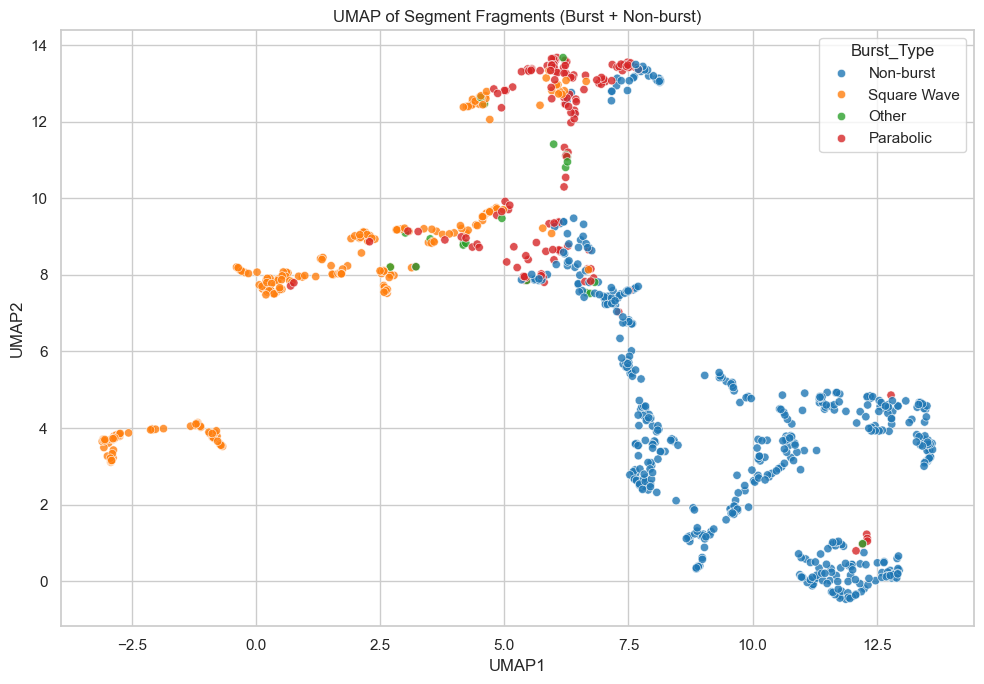

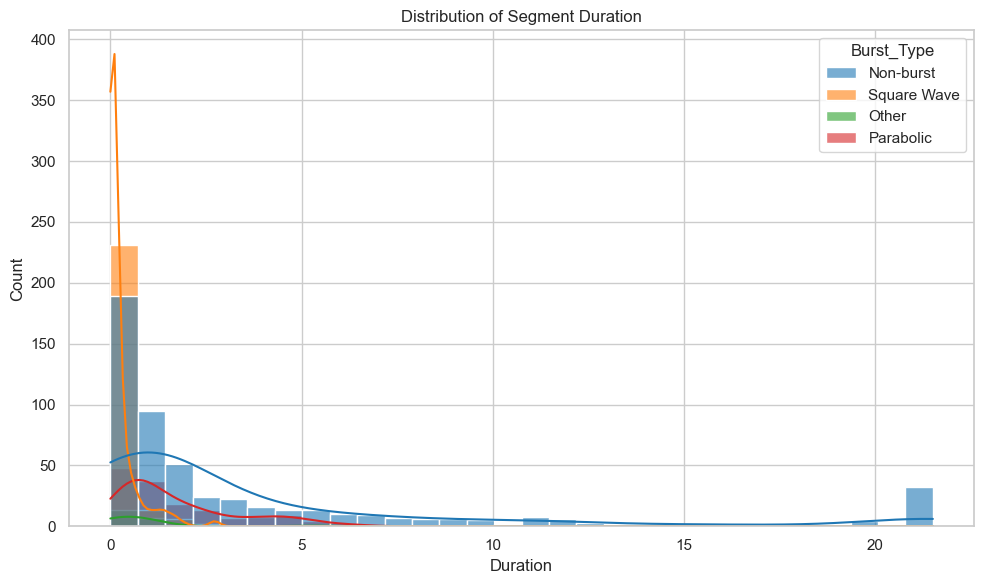

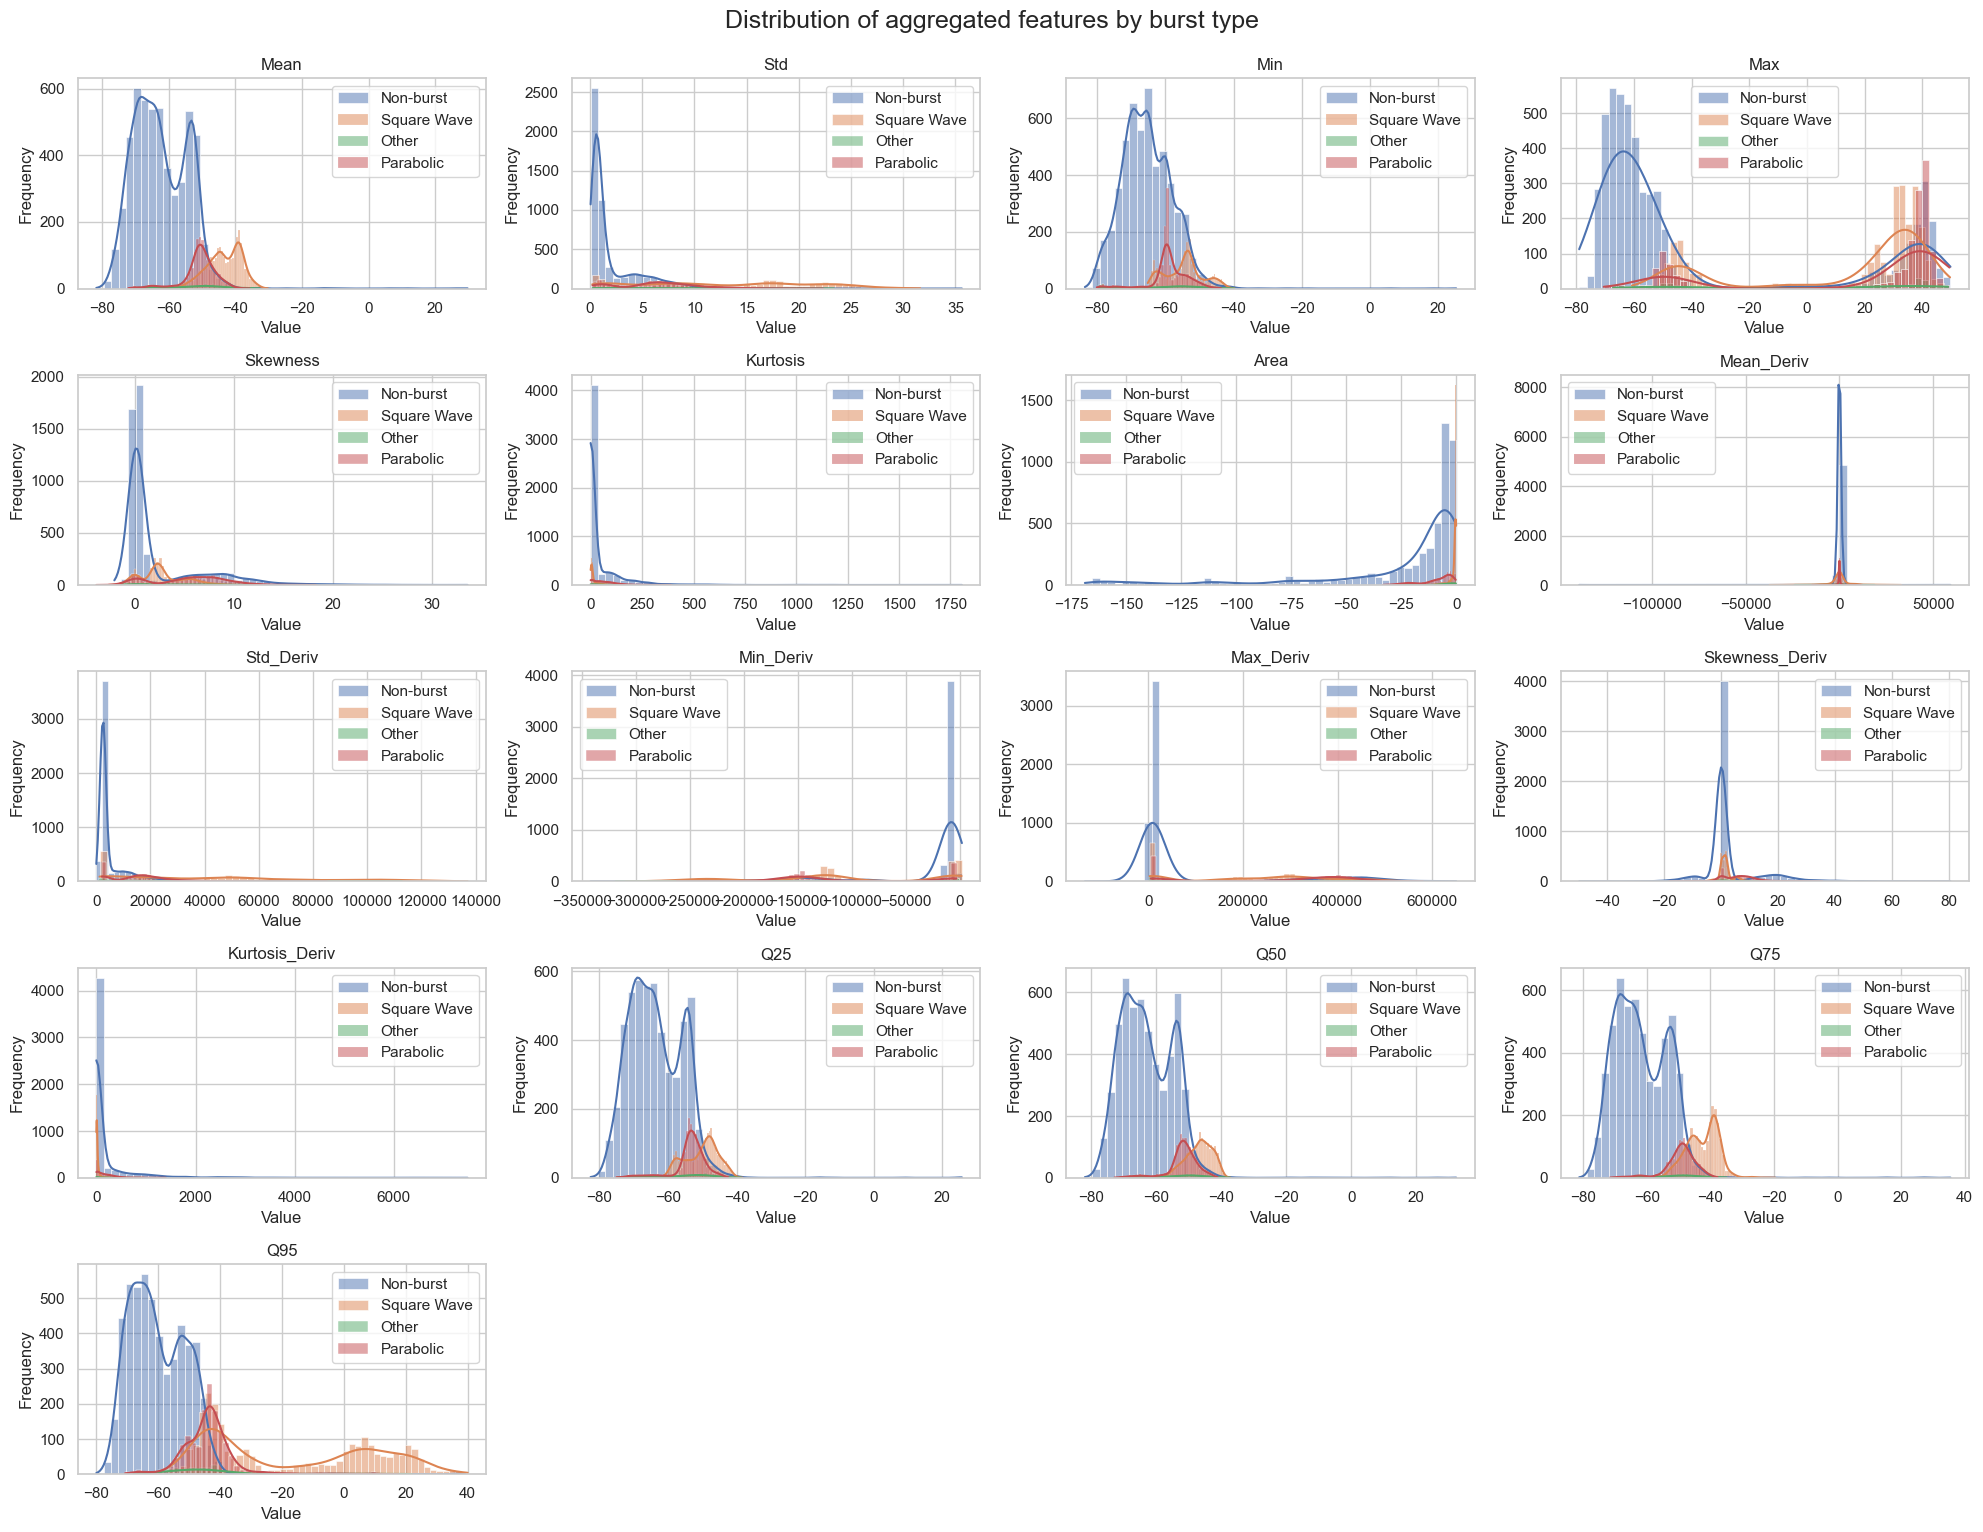

In [30]:
# Static 2D scatterplot (UMAP)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", palette="tab10", alpha=0.8)
plt.title("UMAP of Segment Fragments (Burst + Non-burst)")
plt.tight_layout()
plt.show()

# Histogram of segment durations
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Duration", hue="Burst_Type", bins=30, kde=True, palette="tab10", alpha=0.6)
plt.title("Distribution of Segment Duration")
plt.tight_layout()
plt.show()

# Interactive UMAP (Plotly)
fig = px.scatter(df_umap, x="UMAP1", y="UMAP2", color="Burst_Type", title="UMAP Projection")
fig.show()

# Aggregated histograms for each feature type
feature_bases = [
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv",
    "Skewness_Deriv", "Kurtosis_Deriv",
    "Q25", "Q50", "Q75", "Q95"
]

sns.set(style="whitegrid", context="notebook")
ncols = 4
nrows = int(np.ceil(len(feature_bases) / ncols))
plt.figure(figsize=(20, nrows * 3))

for i, base in enumerate(feature_bases, 1):
    plt.subplot(nrows, ncols, i)
    cols = [f"{base}_{j}" for j in range(1, 11) if f"{base}_{j}" in df.columns]
    for burst_type in df["Burst_Type"].unique():
        subset = df[df["Burst_Type"] == burst_type][cols].values.flatten()
        sns.histplot(subset, bins=50, kde=True, label=burst_type, alpha=0.5)
    plt.title(base)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.suptitle("Distribution of aggregated features by burst type", fontsize=18, y=1.02)
plt.show()



# RANDOM FOREST FEATURE IMPORTANCE ANALYSIS

**Purpose:**
1. Load precomputed segment features from CSV.
2. Encode burst types as numeric labels for classification.
3. Organize 170 fragment features into logical groups.
4. Train a Random Forest classifier on all features.
5. Assess feature group importance using:

    a) Permutation importance (shuffle features to see drop in accuracy)


    b) Drop-group importance (retrain without group to see accuracy drop)

6. Visualize results with bar plots.

- **1. IMPORT LIBRARIES**

pandas, numpy: Data handling

sklearn: Label encoding and Random Forest classifier

matplotlib: Visualization

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder  # Convert categorical labels to numeric integers
from sklearn.ensemble import RandomForestClassifier  # Ensemble of decision trees for classification
import matplotlib.pyplot as plt

- **2. LOAD DATASET**

Load CSV file containing all precomputed segment features

In [32]:
df = pd.read_csv('segment_voltage_metrics_fragments_with_quartiles1.csv')

- **3. PREPARE TARGET VARIABLE**

Burst_Type is categorical (Non-burst, Parabolic, Square Wave, Other)

LabelEncoder converts each category to a numeric integer (required for sklearn classifiers)

In [33]:
le = LabelEncoder()
y = le.fit_transform(df['Burst_Type'])
# Example mapping:
# 0 = Non-burst
# 1,2 = Parabolic or Other (mapping unknown)
# 3 = Square Wave

- **4. DEFINE FEATURE GROUPS**

Organize 170 fragment features into meaningful groups based on type

Each feature type corresponds to 10 fragments (e.g., Mean_1..Mean_10)

In [34]:
feature_types = [
    'Mean', 'Std', 'Min', 'Max', 'Skewness', 'Kurtosis',
    'Area', 'Mean_Deriv', 'Std_Deriv', 'Min_Deriv', 'Max_Deriv',
    'Skewness_Deriv', 'Kurtosis_Deriv', 'Q25', 'Q50', 'Q75', 'Q95'
]

groups = {}
for ft in feature_types:
    # Collect all columns starting with the feature type prefix
    cols = [col for col in df.columns if col.startswith(ft + '_')]
    if cols:
        groups[ft] = cols  # Store in dictionary: group name → list of columns

- **5. CREATE FULL FEATURE MATRIX**

Combine all feature groups into a single matrix for model training

In [35]:
all_cols = [col for cols in groups.values() for col in cols]  # Flatten list of all group columns
X = df[all_cols]  # Feature matrix

- **6. TRAIN RANDOM FOREST MODEL**

Train a classifier to predict burst type from segment features

In [36]:
# Random Forest with 20 trees
model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(X, y)  # Train model on all features

# Compute base accuracy on training set
base_score = model.score(X, y)
print("Base model accuracy:", base_score)

Base model accuracy: 0.9989484752891693


- **7. PERMUTATION IMPORTANCE FUNCTION**

 Estimate importance of each feature group by shuffling its values
 and measuring drop in model accuracy. Larger drop --> more important.

In [37]:
def group_permutation_importance(model, X, y, group_cols, n_iter=5):
    drops = []
    for _ in range(n_iter):
        X_permuted = X.copy()  # Copy to avoid modifying original data
        # Shuffle values of the feature group across samples
        X_permuted[group_cols] = X_permuted[group_cols].sample(frac=1).to_numpy()
        score = model.score(X_permuted, y)  # Accuracy with shuffled group
        drops.append(base_score - score)    # Drop in performance
    return np.mean(drops)  # Average drop over iterations

- **8. COMPUTE PERMUTATION IMPORTANCE FOR EACH GROUP**

In [38]:
group_importances = {
    name: group_permutation_importance(model, X, y, cols)
    for name, cols in groups.items()
}

# Sort groups by descending importance
group_importances = dict(sorted(group_importances.items(), key=lambda x: x[1], reverse=True))
print("Group importances:", group_importances)

Group importances: {'Std': np.float64(0.28075709779179814), 'Std_Deriv': np.float64(0.09863301787592009), 'Max': np.float64(0.010304942166140951), 'Skewness': np.float64(0.007781282860147232), 'Kurtosis': np.float64(0.0067297581493164895), 'Max_Deriv': np.float64(0.005888538380651909), 'Kurtosis_Deriv': np.float64(0.0052576235541535125), 'Min': np.float64(0.004416403785488932), 'Skewness_Deriv': np.float64(0.003154574132492094), 'Min_Deriv': np.float64(0.0029442691903259544), 'Mean': np.float64(0.002523659305993675), 'Mean_Deriv': np.float64(0.0016824395373291167), 'Q95': np.float64(0.0016824395373291167), 'Q75': np.float64(0.0012618296529968375), 'Area': np.float64(0.001051524710830698), 'Q50': np.float64(0.0008412197686645584), 'Q25': np.float64(0.0006309148264984187)}


- **9. VISUALIZE PERMUTATION IMPORTANCE**

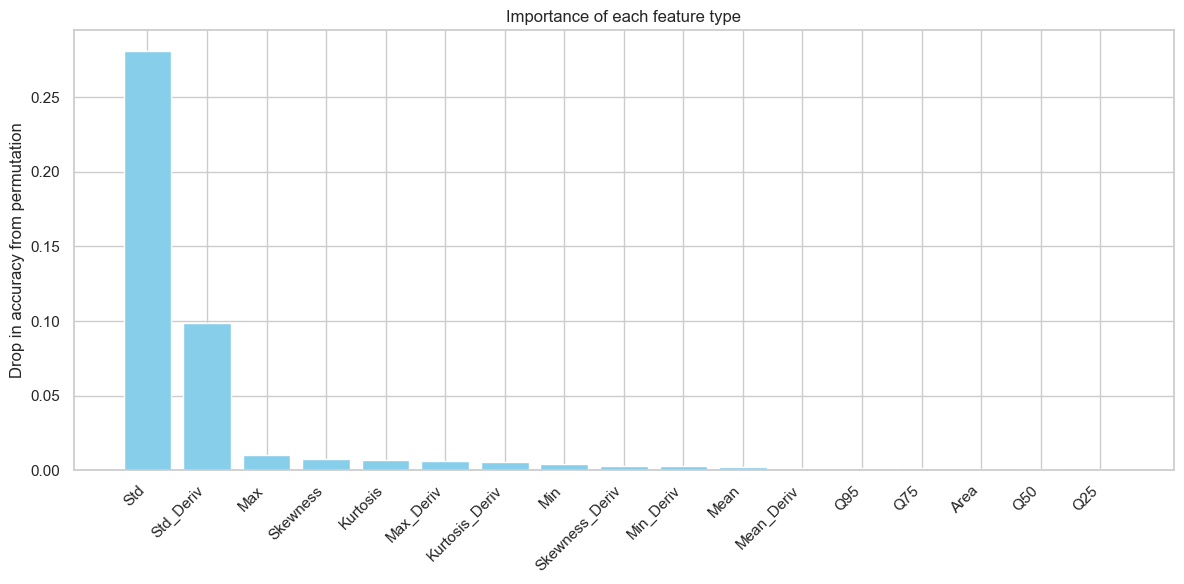

In [39]:
plt.figure(figsize=(12,6))
plt.bar(group_importances.keys(), group_importances.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.ylabel("Drop in accuracy from permutation")
plt.title("Importance of each feature type")
plt.tight_layout()
plt.show()

- **10. DROP-GROUP IMPORTANCE (ALTERNATIVE METHOD)**

Retrain model without each feature group and measure accuracy drop

In [40]:
group_drops = {}
for name, cols in groups.items():
    X_no_group = X.drop(columns=cols)  # Remove current group
    model_tmp = RandomForestClassifier(n_estimators=20, random_state=42)
    model_tmp.fit(X_no_group, y)       # Retrain without this group
    score = model_tmp.score(X_no_group, y)  # Accuracy without group
    drop = base_score - score          # Accuracy drop
    group_drops[name] = drop
    print(f"{name:15s} Accuracy: {score:.4f} | Drop: {drop:.4f}")

# Sort drops to rank feature groups by importance
group_drops = dict(sorted(group_drops.items(), key=lambda x: x[1], reverse=True))
print("\nDrop in accuracy by group (sorted):")
for name, drop in group_drops.items():
    print(f"{name:15s} Drop = {drop:.4f}")

Mean            Accuracy: 0.9979 | Drop: 0.0011
Std             Accuracy: 0.9968 | Drop: 0.0021
Min             Accuracy: 0.9989 | Drop: 0.0000
Max             Accuracy: 0.9979 | Drop: 0.0011
Skewness        Accuracy: 0.9989 | Drop: 0.0000
Kurtosis        Accuracy: 0.9979 | Drop: 0.0011
Area            Accuracy: 0.9989 | Drop: 0.0000
Mean_Deriv      Accuracy: 0.9989 | Drop: 0.0000
Std_Deriv       Accuracy: 0.9979 | Drop: 0.0011
Min_Deriv       Accuracy: 0.9989 | Drop: 0.0000
Max_Deriv       Accuracy: 0.9989 | Drop: 0.0000
Skewness_Deriv  Accuracy: 0.9989 | Drop: 0.0000
Kurtosis_Deriv  Accuracy: 0.9979 | Drop: 0.0011
Q25             Accuracy: 0.9989 | Drop: 0.0000
Q50             Accuracy: 0.9989 | Drop: 0.0000
Q75             Accuracy: 0.9989 | Drop: 0.0000
Q95             Accuracy: 0.9979 | Drop: 0.0011

Drop in accuracy by group (sorted):
Std             Drop = 0.0021
Mean            Drop = 0.0011
Max             Drop = 0.0011
Kurtosis        Drop = 0.0011
Std_Deriv       Drop = 0.00

- **11. VISUALIZE DROP-GROUP IMPORTANCE**

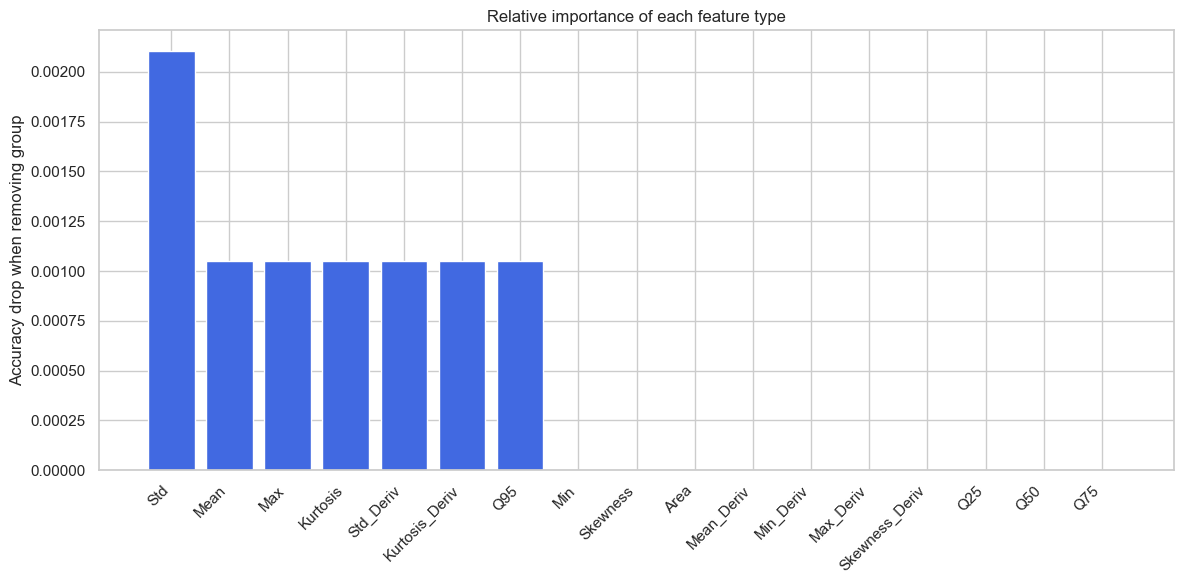

In [41]:
plt.figure(figsize=(12,6))
plt.bar(group_drops.keys(), group_drops.values(), color='royalblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy drop when removing group")
plt.title("Relative importance of each feature type")
plt.tight_layout()
plt.show()


# CLUSTERING AND OUTLIER DETECTION (DBSCAN + LOF)

- **Purpose:**
1. Load precomputed segment features from CSV.
2. Standardize features and compute a 2D UMAP embedding for visualization.
3. Determine candidate eps values for DBSCAN using k-distance analysis.
4. Run DBSCAN with different eps values and evaluate clustering quality.
5. Automatically select the best eps value based on silhouette score or outlier percentage.
6. Run final DBSCAN clustering and Local Outlier Factor (LOF) detection.
7. Combine DBSCAN and LOF for consensus outlier detection.
8. Visualize clusters and outliers.
9. Save results to CSV files.



- **1. IMPORT LIBRARIES**

pandas, numpy: Data handling and numerical computations

matplotlib, seaborn: Plotting and visualization

sklearn.preprocessing: StandardScaler to normalize features

sklearn.neighbors: NearestNeighbors for k-distance analysis; LocalOutlierFactor for outlier detection

sklearn.cluster: DBSCAN clustering algorithm

sklearn.metrics: silhouette_score to assess clustering quality

umap: Dimensionality reduction for embedding high-dimensional features to 2D

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import umap

# Enable interactive matplotlib plots in Jupyter
%matplotlib widget

sns.set(style="whitegrid", context="notebook")  # Set plotting style

- **2. LOAD DATA AND PREPARE FEATURES**

Load precomputed features and prepare numerical feature matrix

In [43]:
df = pd.read_csv("segment_voltage_metrics_fragments_with_quartiles1.csv")

# Exclude non-numerical columns (metadata and labels)
feature_cols = [c for c in df.columns if c not in 
    ["File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration", "Num_Peaks"]]

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols].fillna(0))  # Fill NaN with 0

- **3. COMPUTE 2D UMAP EMBEDDING**

Reduce high-dimensional features to 2D for visualization and clustering

In [44]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Store UMAP coordinates in a DataFrame along with Burst_Type label
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = df["Burst_Type"]

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



- **4. K-DISTANCE ANALYSIS FOR DBSCAN EPS ESTIMATION**

Estimate a suitable eps parameter for DBSCAN by examining distance to nearest neighbors

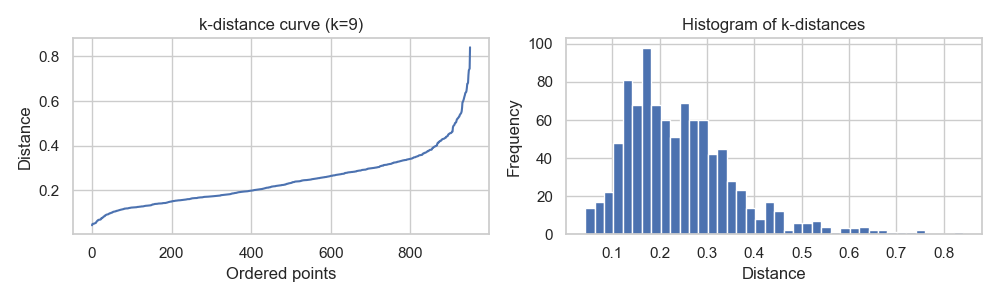

In [45]:
min_samples = 10  # Minimum points in a neighborhood for DBSCAN
k = min_samples - 1  # k for k-distance

# Compute distances to k nearest neighbors for each point
nn = NearestNeighbors(n_neighbors=k)
nn.fit(embedding)
distances, _ = nn.kneighbors(embedding)
k_distances = np.sort(distances[:, -1])  # Distance to kth neighbor for each point

# Plot k-distance curve and histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(k_distances)
axes[0].set_title(f"k-distance curve (k={k})")
axes[0].set_xlabel("Ordered points")
axes[0].set_ylabel("Distance")
axes[1].hist(k_distances, bins=40)
axes[1].set_title("Histogram of k-distances")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

- **5. GENERATE CANDIDATE EPS VALUES**

Generate possible eps values for DBSCAN using jumps and percentiles

In [46]:
diffs = np.diff(k_distances)  # Differences between consecutive distances
eps_jump = float(k_distances[np.argmax(diffs)])  # Largest jump = potential knee point

# Percentile-based eps values
percentiles = [75, 80, 85, 90, 95]
eps_percentiles = [float(np.percentile(k_distances, p)) for p in percentiles]

# Multiplier-based eps values from jump point
multipliers = [0.5, 0.8, 1.0, 1.2, 1.5]
eps_multipliers = [eps_jump * m for m in multipliers]

# Combine all candidate eps values
eps_candidates = sorted(set([eps_jump] + eps_percentiles + eps_multipliers))
print("Candidate eps values:")
for e in eps_candidates:
    print(f"  {e:.4f}")

Candidate eps values:
  0.3012
  0.3236
  0.3453
  0.3728
  0.3880
  0.4567
  0.5965
  0.7457
  0.8948
  1.1185


- **6. EVALUATE DBSCAN FOR EACH EPS**

Test clustering quality across candidate eps values


Results for candidate eps values:
     eps  n_clusters  n_noise  pct_noise  silhouette
0.301198          34      129  13.564669    0.400582
0.323627          32       83   8.727655    0.453534
0.345348          27       63   6.624606    0.434925
0.372829          22       34   3.575184    0.492224
0.387997          20       33   3.470032    0.514131
0.456739          15       11   1.156677    0.441374
0.596527          10        0   0.000000    0.219740
0.745659           5        0   0.000000    0.394279
0.894791           3        0   0.000000    0.203357
1.118488           3        0   0.000000    0.203357


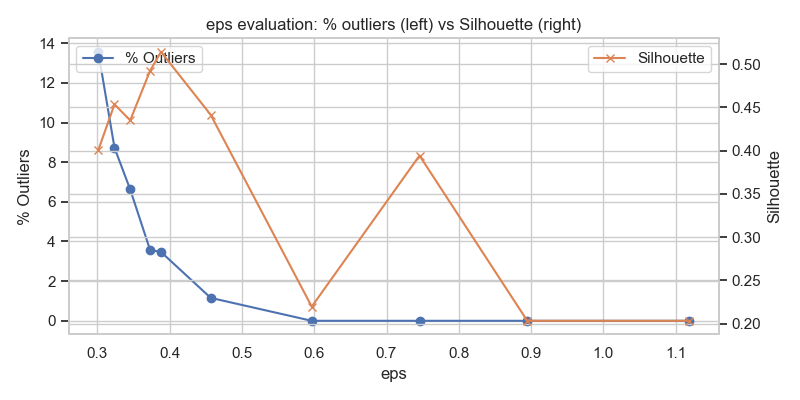

In [47]:
results = []
for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(embedding)

    # Count clusters and outliers
    n_noise = int((labels == -1).sum())
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    pct_noise = 100 * n_noise / len(labels)

    # Compute silhouette score only if more than one cluster exists
    sil = np.nan
    if n_clusters > 1:
        try:
            sil = silhouette_score(embedding, labels)
        except Exception:
            sil = np.nan

    results.append({
        "eps": eps, "n_clusters": n_clusters, "n_noise": n_noise,
        "pct_noise": pct_noise, "silhouette": sil
    })

# Summarize results
df_eps = pd.DataFrame(results).sort_values("eps")
print("\nResults for candidate eps values:")
print(df_eps.to_string(index=False))

# Plot outliers vs silhouette across eps candidates
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(df_eps['eps'], df_eps['pct_noise'], marker='o', label='% Outliers')
ax2.plot(df_eps['eps'], df_eps['silhouette'], marker='x', color='C1', label='Silhouette')
ax1.set_xlabel('eps')
ax1.set_ylabel('% Outliers')
ax2.set_ylabel('Silhouette')
ax1.set_title('eps evaluation: % outliers (left) vs Silhouette (right)')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

- **7. AUTOMATIC SELECTION OF BEST EPS**

Choose optimal eps based on silhouette score or reasonable outlier fraction

In [48]:
valid_sil = df_eps.dropna(subset=['silhouette'])

if not valid_sil.empty:
    best_row = valid_sil.loc[valid_sil['silhouette'].idxmax()]
    eps_selected = float(best_row['eps'])
    reason = f"maximum silhouette ({best_row['silhouette']:.3f})"
else:
    candidates_pct = df_eps[(df_eps['pct_noise'] >= 1) & (df_eps['pct_noise'] <= 10)]
    if not candidates_pct.empty:
        eps_selected = float(candidates_pct.iloc[0]['eps'])
        reason = "pct_noise between 1% and 10%"
    else:
        eps_selected = float(np.percentile(k_distances, 90))
        reason = "90th percentile fallback"

print(f"\nAutomatically selected eps: {eps_selected:.4f}  ({reason})")


Automatically selected eps: 0.3880  (maximum silhouette (0.514))


- **8. FINAL DBSCAN CLUSTERING**

In [49]:
db_final = DBSCAN(eps=eps_selected, min_samples=min_samples)
labels_final = db_final.fit_predict(embedding)
df_umap["DBSCAN_Label"] = labels_final

# Compute cluster and outlier statistics
n_noise = (labels_final == -1).sum()
n_clusters = len(set(labels_final)) - (1 if -1 in labels_final else 0)
pct_noise = 100 * n_noise / len(labels_final)
print(f"Final DBSCAN: {n_clusters} clusters, {n_noise} outliers ({pct_noise:.2f}%)")

Final DBSCAN: 20 clusters, 33 outliers (3.47%)


- **9. LOCAL OUTLIER FACTOR (LOF) DETECTION**

Detect outliers based on local density

In [50]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_labels = lof.fit_predict(embedding)
df_umap["LOF_Label"] = lof_labels
lof_outliers = (lof_labels == -1)
print(f"LOF detected outliers: {lof_outliers.sum()} ({100*lof_outliers.sum()/len(df_umap):.2f}%)")

LOF detected outliers: 35 (3.68%)


- **10. CONSENSUS OUTLIER DETECTION**

Combine DBSCAN and LOF outliers

In [51]:
df_umap["Outlier_DBSCAN"] = df_umap["DBSCAN_Label"] == -1
df_umap["Outlier_LOF"] = df_umap["LOF_Label"] == -1
df_umap["Outlier_Consensus"] = df_umap["Outlier_DBSCAN"] | df_umap["Outlier_LOF"]

n_outliers_cons = df_umap["Outlier_Consensus"].sum()
print(f"Consensus outliers (DBSCAN ∪ LOF): {n_outliers_cons} ({100*n_outliers_cons/len(df_umap):.2f}%)")

Consensus outliers (DBSCAN ∪ LOF): 61 (6.41%)


- **11. VISUALIZE CLUSTERS AND OUTLIERS**

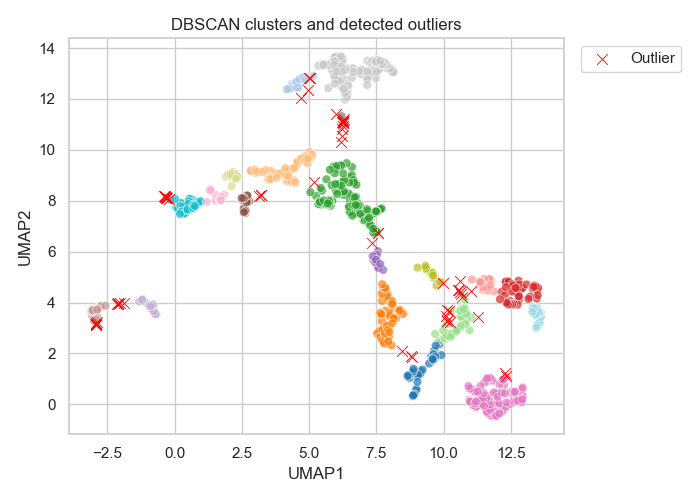

In [52]:
plt.figure(figsize=(7, 5))

# Plot normal points (colored by DBSCAN cluster)
sns.scatterplot(
    data=df_umap[df_umap["Outlier_Consensus"] == False],
    x="UMAP1", y="UMAP2", hue="DBSCAN_Label",
    palette="tab20", s=40, alpha=0.7, legend=False
)

# Plot outliers in red
sns.scatterplot(
    data=df_umap[df_umap["Outlier_Consensus"] == True],
    x="UMAP1", y="UMAP2", color="red", marker="x", s=60, label="Outlier"
)

plt.title("DBSCAN clusters and detected outliers")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

- **12. SAVE RESULTS**

Save consensus outliers and full UMAP dataset with cluster labels

In [53]:
outliers_df = df_umap[df_umap["Outlier_Consensus"]].copy()
outliers_df.to_csv("outliers_consensus_DBSCAN_LOF.csv", index=False)
df_umap.to_csv("UMAP_with_DBSCAN_and_Outliers.csv", index=False)
print("Saved: 'outliers_consensus_DBSCAN_LOF.csv' and 'UMAP_with_DBSCAN_and_Outliers.csv'")

Saved: 'outliers_consensus_DBSCAN_LOF.csv' and 'UMAP_with_DBSCAN_and_Outliers.csv'
